# Horseshoe Prior

In this example, we will use the Horseshoe Prior (Carvalho et al., 2009) to model a large number of variables, with only a few slopes being significantly different from zero. 

In [13]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt

We are simulating 100 observations with the 50 explanatory variables, also simulated. 

In [14]:
D = 50
D0 = 5

SEED = 123456789 # for reproducibility

rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3) # simulate an intercept

COEF = np.zeros(D)
# Simulate the slopes for significant variables
COEF[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100
X = rng.normal(size=(N, D))
SIGMA = 1.
# Simulate the data
y = INTERCEPT + X.dot(COEF) + rng.normal(0, SIGMA, size=N)

Then we create the dataframe and the term name for the set of variables, to define the formula. 

In [15]:
df = pd.DataFrame(X)
df.columns = [f"x{i}" for i in range(X.shape[1])]
df["y"] = y

In [16]:
term_name = "c(" + ", ".join([f"x{i}" for i in range(X.shape[1])]) + ")"
formula = f"y ~ {term_name}"
formula

'y ~ c(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49)'

Finally, we call the Horseshoe prior and create the model

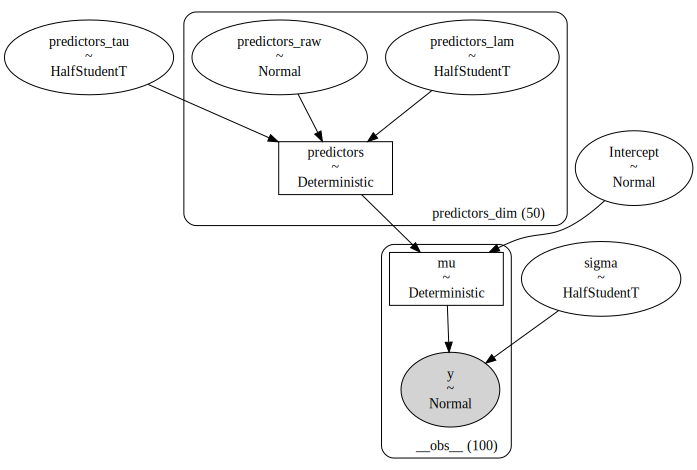

In [17]:
priors = {
    term_name: bmb.Prior("Horseshoe"),
}
model = bmb.Model(formula, df, priors=priors)
model.set_alias({term_name: "predictors"})

model.build()
model.graph()

In [18]:
idata = model.fit(target_accept = 0.95, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, predictors_tau, predictors_lam, predictors_raw]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 444 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


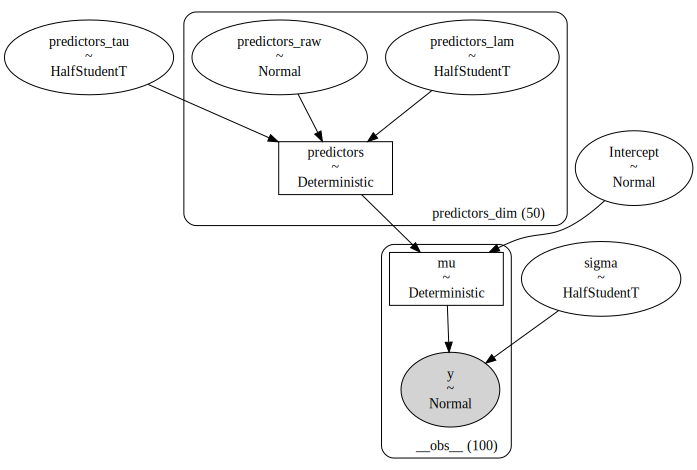

In [19]:
priors = {
    term_name: bmb.Prior("Horseshoe", tau_nu = 3, lam_nu = 3),
}
model = bmb.Model(formula, df, priors=priors)
model.set_alias({term_name: "predictors"})

model.build()
model.graph()

In [20]:
idata = model.fit(target_accept = 0.97, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, predictors_tau, predictors_lam, predictors_raw]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 293 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


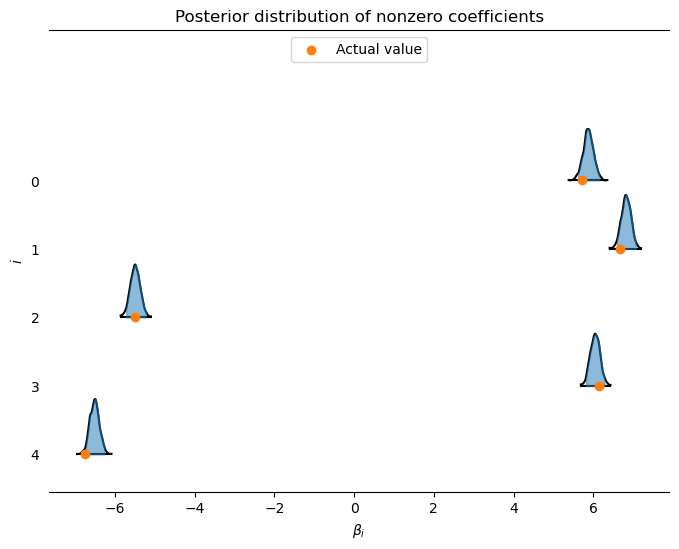

In [21]:
ax, = az.plot_forest(
    idata, 
    var_names=["predictors"], 
    coords={"predictors_dim": range(D0)},
    kind='ridgeplot',
    ridgeplot_truncate=False, 
    ridgeplot_alpha=0.5,
    hdi_prob=0.95, 
    combined=True,
    figsize=(8, 6)
)
ax.scatter(COEF[:D0][::-1], ax.get_yticks(), c='C1', label="Actual value");
ax.set_xlabel(r"$\beta_i$");
ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D0)[::-1]);
ax.set_ylabel(r"$i$");
ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Aug 22 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

pandas    : 2.2.2
numpy     : 1.26.4
bambi     : 0.14.1.dev12+g64e57423.d20240730
arviz     : 0.18.0
matplotlib: 3.8.4
pymc      : 5.16.1
pytensor  : 2.23.0

Watermark: 2.4.3

